In [50]:
import xarray as xr
import rioxarray
from pathlib import Path
import rasterio
time_series_folder = '../output_folder/snow_cover_extent_analysis'
area_stats_stats_name = 'WY_2023_2024_area_forest_with_snow.nc'


area_stats_path= Path(f"{time_series_folder}").joinpath(area_stats_stats_name)
area_stats = xr.open_dataset(area_stats_path)

In [51]:
from metrics import WinterYear
def assign_time_coord(area_stats: xr.DataArray)-> xr.DataArray:
    return area_stats.roll(month=-9,roll_coords=True).assign_coords({'month': WinterYear(2023,2024).to_datetime()}).rename({'month': 'time'})

area_stats = assign_time_coord(area_stats)
area_stats = area_stats.rename({'product_1': "Meteo-France", "product_2": "NASA"})

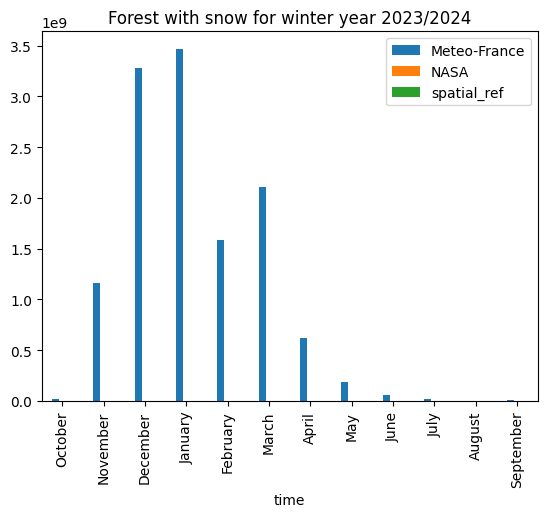

In [52]:
def plot_bar(data_array: xr.DataArray):
    df = data_array.to_pandas()
    df.index = df.index.strftime("%B")
    df.plot.bar(title=f"Forest with snow for winter year 2023/2024")

plot_bar(area_stats)

In [24]:
from typing import List
from matplotlib.axes import Axes
import pandas as pd

def print_table( year_stats_data_array: xr.DataArray, classes_to_print: List[str] | str = "all"):
    year_data_frame = year_stats_data_array.to_pandas()
    pd.options.display.float_format = "{:.3f}".format
    pd.options.display.precision = 3
    if classes_to_print == "all":
        classes_to_print = year_stats_data_array.coords["class_name"].values
    print(year_data_frame)

def classes_bar_distribution(
    year_stats_data_array: xr.DataArray, classes_to_plot: List[str] | str = "all", ax: Axes | None = None
) -> None:
    year_data_frame = year_stats_data_array.to_pandas()
    print(year_data_frame)
    if classes_to_plot == "all":
        classes_to_plot = year_data_frame.index

    year_data_frame = year_data_frame.transpose()
    year_data_frame.index = year_data_frame.index.strftime("%B")
    year_data_frame[classes_to_plot].plot.bar(title=f"Class distribution for year ", ax=ax)

In [25]:
classes_bar_distribution(area_stats, classes_to_plot="forest_with_snow")
#area_stats.assign_coords('time')

               product_1  product_2  spatial_ref
time                                            
2023-10-01  2.329839e+07          0            0
2023-11-01  1.166787e+09          0            0
2023-12-01  3.282585e+09          0            0
2023-01-01  3.467847e+09          0            0
2023-02-01  1.582899e+09          0            0
2023-03-01  2.106978e+09          0            0
2023-04-01  6.218479e+08          0            0
2023-05-01  1.900323e+08          0            0
2023-06-01  5.621458e+07          0            0
2023-07-01  1.472159e+07          0            0
2023-08-01  3.118952e+06          0            0
2023-09-01  9.787500e+06          0            0


AttributeError: 'Index' object has no attribute 'strftime'

In [3]:
area_stats.reset_index('month', drop = True)

<xarray.Dataset> Size: 200B
Dimensions:      (month: 12)
Coordinates:
    spatial_ref  int64 8B ...
Dimensions without coordinates: month
Data variables:
    product_1    (month) float64 96B ...
    product_2    (month) int64 96B ...

In [5]:

#area_stats.rename({'month': 'time'})

<xarray.Dataset> Size: 296B
Dimensions:      (time: 12)
Coordinates:
    spatial_ref  int64 8B ...
  * time         (time) datetime64[ns] 96B 2023-10-01 2023-11-01 ... 2023-09-01
Data variables:
    product_1    (time) float64 96B ...
    product_2    (time) int64 96B ...